<a href="https://colab.research.google.com/github/helvete74/IFAGE_dev_AI/blob/main/Efficient_Object_Detection_with_YOLOV8_and_KerasCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TUTO Efficient Object Detection with YOLOV8 and KerasCV

https://keras.io/examples/vision/yolov8/

In [2]:
!pip install roboflow

In [3]:
# download the dataset from roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="4RTem5JDv2kRxw8jk1El")

# version yoloV8
# project = rf.workspace("roboflow-gw7yv").project("self-driving-car")
# version = project.version(3)
# dataset = version.download("yolov8")

#Pascal VOC XML
project = rf.workspace("roboflow-gw7yv").project("self-driving-car")
version = project.version(3)
dataset = version.download("voc")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Self-Driving-Car-3 in voc:: 100%|██████████| 59603/59603 [00:07<00:00, 7949.85it/s]


install KerasCV

In [4]:
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 18.3 MB/s eta 0:00:00


Import lib

In [5]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization


Using TensorFlow backend


Hyperparameters

In [6]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0


A dictionary is created to map each class name to a unique numerical identifier. This mapping is used to encode and decode the class labels during training and inference in object detection tasks.

In [7]:
'''
class_ids = [
    "car",
    "pedestrian",
    "trafficLight",
    "biker",
    "truck",
]
'''
# class_ids from the Udacity Self Driving Car Dataset
class_ids = [
    "car",
    "pedestrian",
    "trafficLight-Red",
    "trafficLight-Green",
    "truck",
    "trafficLight",
    "biker",
    "trafficLight-RedLeft",
    "trafficLight-GreenLeft",
    "trafficLight-Yellow",
    "trafficLight-YellowLeft"
]



class_mapping = dict(zip(range(len(class_ids)), class_ids))
class_mapping

{0: 'car',
 1: 'pedestrian',
 2: 'trafficLight-Red',
 3: 'trafficLight-Green',
 4: 'truck',
 5: 'trafficLight',
 6: 'biker',
 7: 'trafficLight-RedLeft',
 8: 'trafficLight-GreenLeft',
 9: 'trafficLight-Yellow',
 10: 'trafficLight-YellowLeft'}

In [8]:
# Path to images and annotations
# path_images = "/kaggle/input/dataset/data/images/"
# path_annot = "/kaggle/input/dataset/data/annotations/"
# local path :
path_annot = "Self-Driving-Car-3/export"
path_images  = "Self-Driving-Car-3/export"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

In [9]:
jpg_files

['Self-Driving-Car-3/export/1478019952686311006_jpg.rf.54e2d12dbabc46be3c78995b6eaf3fee.jpg',
 'Self-Driving-Car-3/export/1478019952686311006_jpg.rf.JLSB3LP2Q4RuGHYKqfF6.jpg',
 'Self-Driving-Car-3/export/1478019953180167674_jpg.rf.8a816c9d7e9b423a63ed6ecd4a663e47.jpg',
 'Self-Driving-Car-3/export/1478019953180167674_jpg.rf.azslsZnM8FLQPu3QWLTl.jpg',
 'Self-Driving-Car-3/export/1478019953689774621_jpg.rf.2e4b7ae29c3379da1282e85cff4c1745.jpg',
 'Self-Driving-Car-3/export/1478019953689774621_jpg.rf.UpOkvtBppZZaLfvVZ0JX.jpg',
 'Self-Driving-Car-3/export/1478019954186238236_jpg.rf.cbpP963e2sN7rHIZMJtD.jpg',
 'Self-Driving-Car-3/export/1478019954186238236_jpg.rf.f8ac6ad31e400d4918ff394f903bb95c.jpg',
 'Self-Driving-Car-3/export/1478019954685370994_jpg.rf.049fda8ca86adf1e404b41955eb4aba8.jpg',
 'Self-Driving-Car-3/export/1478019954685370994_jpg.rf.Jah8pEPis5n1x6iQCtmT.jpg',
 'Self-Driving-Car-3/export/1478019955185244088_jpg.rf.gJpj2eCO1Dd7Sic9WlhE.jpg',
 'Self-Driving-Car-3/export/1478019955

In [10]:
xml_files

['Self-Driving-Car-3/export/1478019952686311006_jpg.rf.54e2d12dbabc46be3c78995b6eaf3fee.xml',
 'Self-Driving-Car-3/export/1478019952686311006_jpg.rf.JLSB3LP2Q4RuGHYKqfF6.xml',
 'Self-Driving-Car-3/export/1478019953180167674_jpg.rf.8a816c9d7e9b423a63ed6ecd4a663e47.xml',
 'Self-Driving-Car-3/export/1478019953180167674_jpg.rf.azslsZnM8FLQPu3QWLTl.xml',
 'Self-Driving-Car-3/export/1478019953689774621_jpg.rf.2e4b7ae29c3379da1282e85cff4c1745.xml',
 'Self-Driving-Car-3/export/1478019953689774621_jpg.rf.UpOkvtBppZZaLfvVZ0JX.xml',
 'Self-Driving-Car-3/export/1478019954186238236_jpg.rf.cbpP963e2sN7rHIZMJtD.xml',
 'Self-Driving-Car-3/export/1478019954186238236_jpg.rf.f8ac6ad31e400d4918ff394f903bb95c.xml',
 'Self-Driving-Car-3/export/1478019954685370994_jpg.rf.049fda8ca86adf1e404b41955eb4aba8.xml',
 'Self-Driving-Car-3/export/1478019954685370994_jpg.rf.Jah8pEPis5n1x6iQCtmT.xml',
 'Self-Driving-Car-3/export/1478019955185244088_jpg.rf.gJpj2eCO1Dd7Sic9WlhE.xml',
 'Self-Driving-Car-3/export/1478019955

In [11]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)


  0%|          | 0/29800 [00:00<?, ?it/s]

In [12]:
classes

[[4, 0, 0, 1],
 [4, 0, 0, 1],
 [4, 0, 4, 0],
 [4, 0, 4, 0],
 [1, 4, 0, 0, 0, 0],
 [1, 4, 0, 0, 0, 0],
 [1, 4, 0, 0, 0, 0],
 [1, 4, 0, 0, 0, 0],
 [1, 4, 0, 0, 0],
 [1, 4, 0, 0, 0],
 [1, 4, 0, 0, 0],
 [4, 1, 0, 4, 0],
 [4, 1, 0, 4, 0],
 [0, 0, 1, 0, 4, 0],
 [0, 0, 1, 0, 4, 0],
 [0, 0, 0, 0, 1, 0, 4, 0],
 [0, 0, 0, 0, 1, 0, 4, 0],
 [0, 0, 0, 0, 1, 0, 4, 0, 0],
 [0, 0, 0, 0, 1, 0, 4, 0, 0],
 [0, 0, 0, 0, 0, 4, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 4, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 4, 0, 0, 0],
 [0, 0, 0, 0, 0, 4, 0, 0, 0],
 [0, 0, 1, 4, 0, 0],
 [0, 0, 1, 4, 0, 0],
 [0, 0, 0, 0, 4, 0, 0],
 [0, 0, 0, 0, 4, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0,

In [13]:
# create irregular tensor with tf.ragged
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

# create the dataset
data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))


Splitting data in training and validation data

In [14]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)




```
bounding_boxes = {
    # num_boxes may be a Ragged dimension
    'boxes': Tensor(shape=[batch, num_boxes, 4]),
    'classes': tf.Tensor(shape=[batch, num_boxes])
}
```




In [15]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # add resize image
    # image = tf.image.resize(image, (512, 512))
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

Data Augmentation

In [16]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)


In [17]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

Creating Training Dataset

In [18]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
# train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE) # with augmenter
train_ds = train_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE) # with resizing like val_ds

Creating Validation Dataset

In [19]:
'''

resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)
'''
val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

Visualization

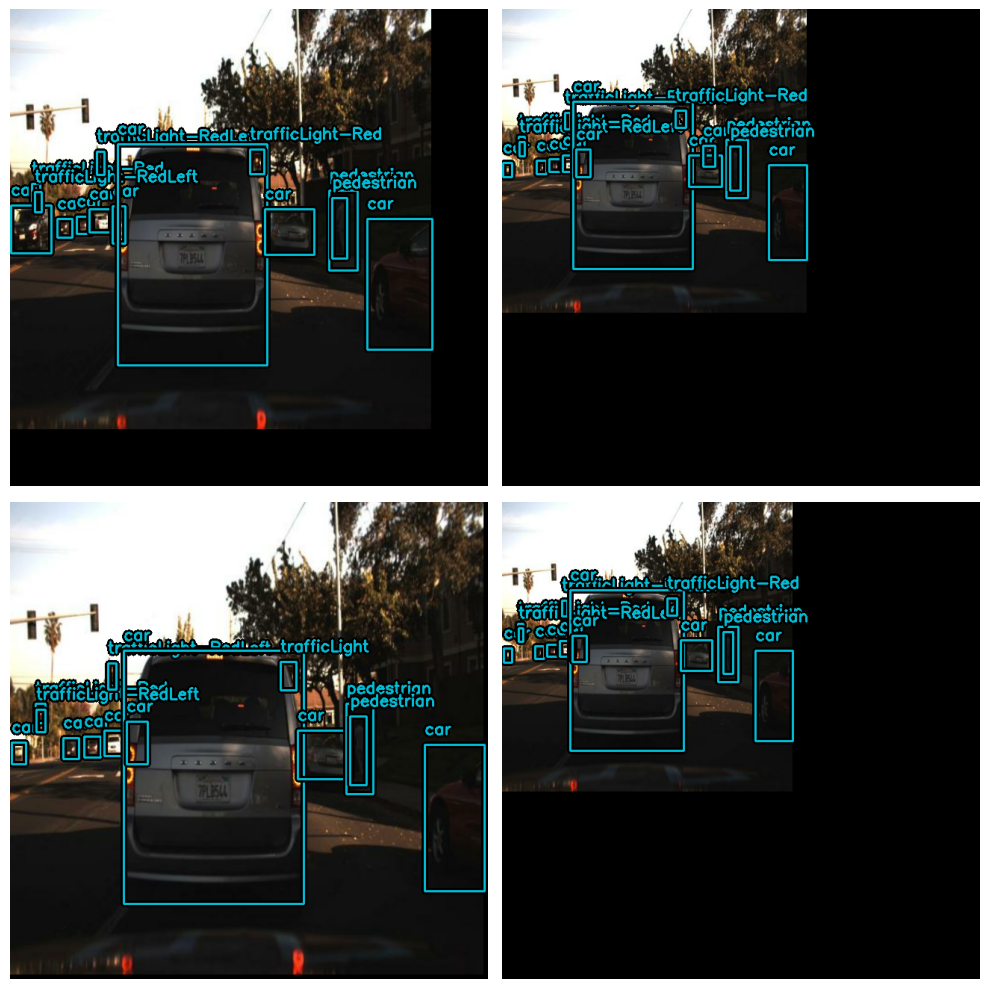

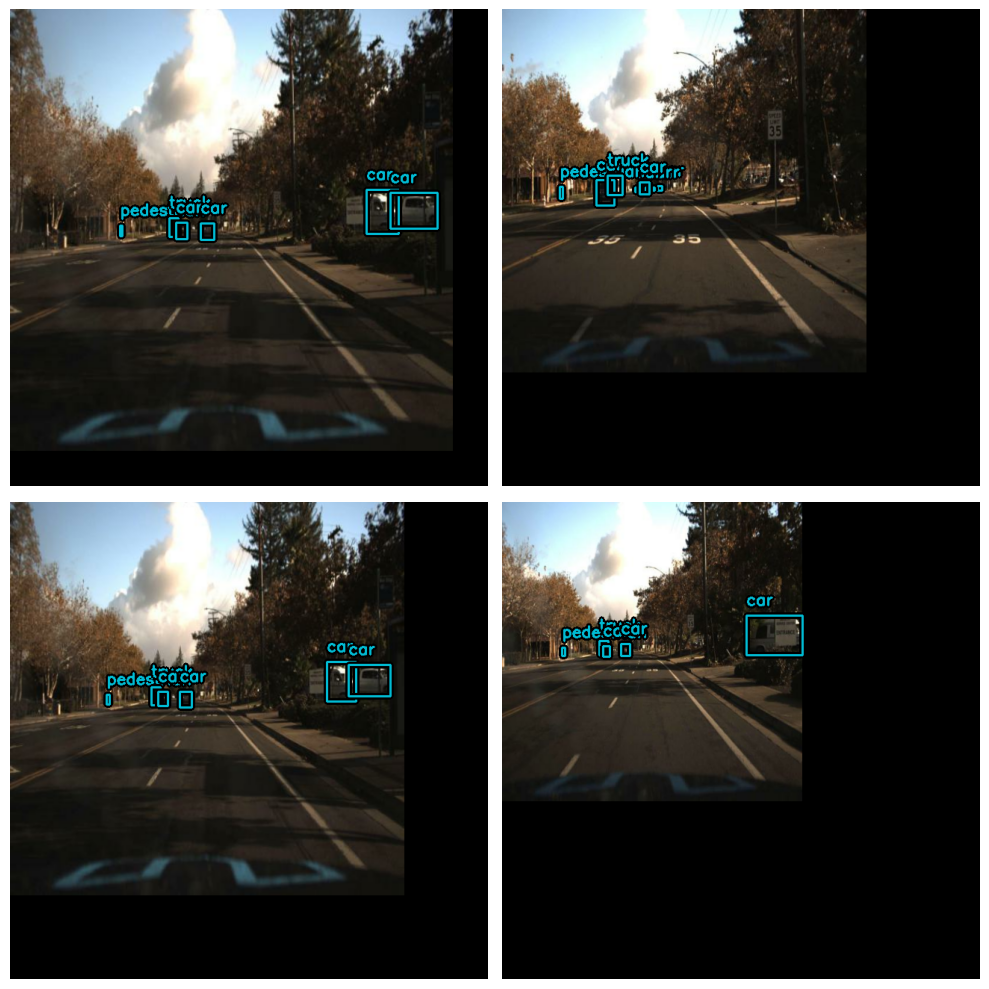

In [20]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

We need to extract the inputs from the preprocessing dictionary and get them ready to be fed into the model.

In [21]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [22]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(4, 640, 640, 3), dtype=tf.float32, name=None), {'classes': RaggedTensorSpec(TensorShape([4, None]), tf.float32, 1, tf.int64), 'boxes': RaggedTensorSpec(TensorShape([4, None, None]), tf.float32, 1, tf.int64)})>

Creating Model\
the Yolov8 model : https://blog.roboflow.com/whats-new-in-yolov8/

Avec un model pre-entrainer sur des données COCO

In [23]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

100%|██████████| 646/646 [00:00<00:00, 1.04MB/s]
100%|██████████| 19.7M/19.7M [00:02<00:00, 7.44MB/s]
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


integration de nos paramètres :

In [24]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

Compile the Model

In [25]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

COCO Metric Callback

In [26]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    # surcharge _box_concat pour concatene des tenseurs de differentes formes
    def _box_concat(self, boxes):
        """Concatenate boxes from different tensors."""
        result = {}
        shapes = set()
        for b in boxes:
            shapes.add(tf.shape(b["boxes"])[0])

        if len(shapes) > 1:
            raise ValueError("All boxes must have the same number of instances.")

        for key in boxes[0]:
            result[key] = tf.concat([b[key] for b in boxes], axis=0)

        return result

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs


Train the Model

Pronblème:\
error : ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [4,9,4] vs. shape[2] = [4,6,4]\
Ajout de :\
image = tf.image.resize(image, (512, 512)) #add resize image\
même chose\
je ne sais pas comment ajuster le train_label
>> utilisation de resizing dans le df de train et de validation

relance\
error : ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [4,5,4] vs. shape[1] = [4,9,4] [Op:ConcatV2]
suggestion :\
The error is caused by a dimension mismatch in the _box_concat function within the BoxCOCOMetrics class. Specifically, the function is attempting to concatenate tensors with different shapes along the first axis.\
modification de COCOMetricsCallback\
Toujours la meme erreur.
:(
  





In [27]:
'''
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)
'''

'\nyolo.fit(\n    train_ds,\n    validation_data=val_ds,\n    epochs=3,\n    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],\n)\n'

In [28]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
5960/5960 [==============================] - 1247s 201ms/step - loss: 4.1254 - box_loss: 2.1707 - class_loss: 1.9547 - val_loss: 2.8475 - val_box_loss: 2.5702 - val_class_loss: 0.2773
Epoch 2/3
5960/5960 [==============================] - 1197s 201ms/step - loss: 2.0478 - box_loss: 1.8850 - class_loss: 0.1628 - val_loss: 2.5453 - val_box_loss: 2.3185 - val_class_loss: 0.2268
Epoch 3/3
5960/5960 [==============================] - 1195s 201ms/step - loss: 1.9109 - box_loss: 1.7654 - class_loss: 0.1454 - val_loss: 2.4531 - val_box_loss: 2.2431 - val_class_loss: 0.2100
